<a href="https://colab.research.google.com/github/mbc2009/Lmp_ML/blob/main/Model_trainning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Enviornment Initialization

In [1]:
%%capture
%%bash

# remove unnecessary
rm -rf *

# update pip
python -m pip install --upgrade pip

# install package
pip install opencv-python pillow
pip install segmentation_models_pytorch
pip install -q kaggle
pip install dropbox
pip install scikit-image
pip install pandas openpyxl

In [2]:
# basic import
import  os, sys, time, math, random, math, psutil, h5py, re
from    concurrent.futures      import ThreadPoolExecutor
from    typing                  import  List, Tuple
from    dropbox                 import  Dropbox
from    tqdm                    import  tqdm
from    mpl_toolkits.mplot3d    import  Axes3D
from    matplotlib              import  pyplot      as plt
import  numpy                                       as np
import  pandas                                      as pd
import  zipfile
import  warnings
import  shutil

from    sklearn.preprocessing   import MinMaxScaler
from    skimage                 import  io
from    scipy                   import  interpolate
from    scipy.interpolate       import  RegularGridInterpolator
from    scipy.ndimage           import  generic_filter, rotate
from    PIL                     import  Image

import  torch
from    torch                   import  nn
from    torch.nn                import  functional  as F
import  torch.optim                                 as optim
import  torchvision.transforms.functional           as TF
from    torch.utils.data        import  Dataset, DataLoader, TensorDataset, random_split, Subset
from    torchvision             import  transforms, models
from    torchvision.transforms  import  *
import  kagglehub

In [3]:
# check hardware
print(f"CPU core #:\t{os.cpu_count()}")
print(f"CPU threads #:\t{psutil.cpu_count(logical=True)}")
print(f"Total memory:\t\t{psutil.virtual_memory().total / (1024**3):.2f} GB")
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"available GPU #:\t{gpu_count}")
    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i+1}:\t\t{gpu_name}")
else:
    print("No available GPU")

CPU core #:	12
CPU threads #:	12
Total memory:		83.48 GB
available GPU #:	1
GPU 1:		NVIDIA A100-SXM4-40GB


# 1. Configuration

In [12]:
class Confuration():
  # define paths to directory
  home_dir                = os.path.expanduser("~")
  working_dir             = os.path.join(os.getcwd(),'Lmp_ML')
  DataBase_dir            = os.path.join(working_dir,'DataBase')
  DB_version              = 5
  DB_3D_Grids_density     = 128
  DB_3D_Grids_path        = os.path.join(DataBase_dir, f'{DB_version}', f'3D_Grids_{DB_3D_Grids_density}.h5') # TODO: choose database version, here ver=4
  DB_Excel_path           = os.path.join(working_dir,  f'LmpGP.xlsx')                                         # TODO: choose database version, here ver=4

  # dataset
  DB_items                = ['pore_radius\n(A)', 'density\n(g/cm^3)']

  # debug
  dev_mode                = False

conf = Confuration()

In [5]:
# import code from git hub
!git clone https://github.com/mbc2009/Lmp_ML

Cloning into 'Lmp_ML'...
remote: Enumerating objects: 565, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 565 (delta 35), reused 11 (delta 4), pack-reused 450 (from 3)
Receiving objects: 100% (565/565), 134.16 MiB | 30.46 MiB/s, done.
Resolving deltas: 100% (251/251), done.


In [6]:
# make directory
os.makedirs(conf.DataBase_dir, exist_ok=True)

In [7]:
# download
original_path = kagglehub.dataset_download("mbc2009/heat-and-mass-transfer",force_download=True)
shutil.move(original_path, conf.DataBase_dir)

100%|██████████| 1.38G/1.38G [00:08<00:00, 173MB/s]

Extracting files...


'/content/Lmp_ML/DataBase/5'

# 2.Functions and Classes

In [13]:
def check_hdf5_content(file_path:str,PrintStrcut=False)->int:
  '''
  check the content (name, quantity) of hdf5 file
  input:
    file_path: the path of hdf5 file
    PrintStrcut: print the structure of hdf5 file
  return:
    the name and quantity of variables in hdf5 file
  '''
  # 初始化数据集计数器
  dataset_count = 0

  # 定义一个内部函数用于遍历 HDF5 文件内部
  def count_datasets(name, obj):
        nonlocal dataset_count
        if isinstance(obj, h5py.Dataset):  # 判断是否为数据集
            dataset_count += 1
        elif isinstance(obj, h5py.Group):  # 判断是否为组
            pass  # 如果是组，不计数

  with h5py.File(file_path, "r") as h5f:

        # 遍历文件内容以计数
        h5f.visititems(count_datasets)

        # 打印所有内变量名字
        if PrintStrcut:
          print(f"文件结构:")
          h5f.visit(print)

  print(f'文件数: {dataset_count}')

  return dataset_count # 文件数

# 3.Prepare Data Base

## 3.1. Check Excel data base

In [14]:
# convert Excel data into pandas data frame
df = pd.read_excel(conf.DB_Excel_path, engine="openpyxl")

In [15]:
if conf.dev_mode:
  # 打印形状
  print(df.shape)

  # 读取列名
  print(df.columns)

(836, 58)
Index(['len\n(A)', 'sigma\n(A)', 'temp\n(k)', 'flux\n(L/m^2/h)',
       'density\n(g/cm^3)', 'density(rectified)\n(g/cm^3)',
       'thermal_conductivity\n(W/(m·K))',
       'thermal_conductivity(rectified)\n(W/(m·K))', 'mass\n(g)',
       'valume of box\n(A^3)', 'bond_density\n(unitless)',
       'thickness_of_box\n(A)', 'thickness_of_GP\n(A)', 'surface_area\n(A^2)',
       'specific_surface_area\n(m^2/g)', 'porosity\n(unitless)',
       'tortuosity\n(unitless)', 'pore_radius\n(A)', 'Unnamed: 18',
       'Diffusivity_Knudsen_PoreRadius\n(m^2/s)',
       'Diffusivity_Knudsen_peak\n(m^2/s)', 'Knudsen_number_PoreRadius',
       'Knudsen_number_peak', 'Unnamed: 23',
       'Diffusivity_EA_filtrates\n_in_membrane\n(m^2/s)',
       'Diffusivity_TA_filtrates\n_in_membrane\n(m^2/s)',
       'Diffusivity_EA_filtrates\n_in_FeedTank\n(m^2/s)',
       'Diffusivity_TA_filtrates\n_in_FeedTank\n(m^2/s)',
       'Diffusivity_EA_feeds\n_in_FeedTank\n(m^2/s)',
       'Diffusivity_TA_feeds\n_i

In [16]:
if conf.dev_mode:
  # 筛选列名对应列
  df = df.loc[:, ['len\n(A)', 'sigma\n(A)', 'temp\n(k)', 'flux\n(L/m^2/h)', 'density\n(g/cm^3)']]

In [17]:
def fetch_from_pandas(len_i: int, sigma_i: int, temp_i: int, items: List[str], df: pd.DataFrame) -> torch.Tensor:
    """
    根据 len_i, sigma_i, temp_i 在 pandas DataFrame 中查找指定 items，并返回一个 PyTorch Tensor。

    Args:
        len_i (int):        目标 len 值
        sigma_i (int):      目标 sigma 值
        temp_i (int):       目标 temp 值
        items (List[str]):  需要提取的列名列表
        df (pd.DataFrame):  数据源 Pandas DataFrame

    Returns:
        Optional[torch.Tensor]: 若找到数据，则返回一个 Float32 类型的 PyTorch Tensor，否则返回 None。
    """
    try:
        # 筛选符合条件的行，并提取多个列
        item_values = df.loc[
            (df["len\n(A)"] == len_i) &
            (df["sigma\n(A)"] == sigma_i) &
            (df["temp\n(k)"] == temp_i),
            items
        ]

        # 确保只有一行数据，转换为 Tensor
        if not item_values.empty:
            tensor_values = torch.tensor(item_values.values.flatten(), dtype=torch.float32)
            return tensor_values
        else:
            return None  # 没有匹配数据时返回 None

    except KeyError as e:
        print(f"列名错误: {e}")
        return None

    except ValueError as e:
        print(f"数据转换错误: {e}")
        return None

In [18]:
if conf.dev_mode:
  # 使用示例
  items = fetch_from_pandas(len_i= 2, sigma_i=8, temp_i=373, items=['density\n(g/cm^3)'], df=df)
  print(items[0].item())

0.37132611870765686


## 3.2.Check grid data base

In [19]:
if conf.dev_mode:
  # 查看hdf5文件内容
  num_grids = check_hdf5_content(conf.DB_3D_Grids_path,PrintStrcut=False)

文件数: 836


In [20]:
if conf.dev_mode:
  # 查看单个数据点
  DB_3D_Grids = h5py.File(conf.DB_3D_Grids_path, "r")
  GA          = DB_3D_Grids[f"len_{2}_sigma_{18}_{343}"][:]
  print(f'矩阵形状:   {GA.shape}')
  print(f'矩阵最大值: {np.max(GA)}')
  print(f'矩阵最小值: {np.min(GA)}')
  print(f"矩阵 GA 中 {np.max(GA)} 的数量：{np.count_nonzero(GA == np.max(GA)) }")

矩阵形状:   (128, 128, 128)
矩阵最大值: 3.0
矩阵最小值: 0.0
矩阵 GA 中 3.0 的数量：3


In [21]:
# 可视化函数
def plot_3D_Grid(matrix_3d):
    """
    绘制三维点阵的三视图（正视图、侧视图、俯视图）。

    Args:
        matrix_3d (numpy.ndarray): 三维点阵数据。

    Returns:
        None
    """
    # 创建图形和坐标轴
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 俯视图 (X-Y 平面)
    axes[0].imshow(np.sum(matrix_3d, axis=0), cmap='viridis')  # 沿 Z 轴求和
    axes[0].set_title('Top View (X-Y)')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')

    # 正视图 (Z-X 平面)
    axes[1].imshow(np.sum(matrix_3d, axis=1), cmap='viridis')  # 沿 Y 轴求和
    axes[1].set_title('Front View (Z-X)')
    axes[1].set_xlabel('Z')
    axes[1].set_ylabel('X')

    # 侧视图 (Z-Y 平面)
    axes[2].imshow(np.sum(matrix_3d, axis=2), cmap='viridis')  # 沿 X 轴求和
    axes[2].set_title('Side View (Z-Y)')
    axes[2].set_xlabel('Z')
    axes[2].set_ylabel('Y')

    # 显示图形
    plt.show()

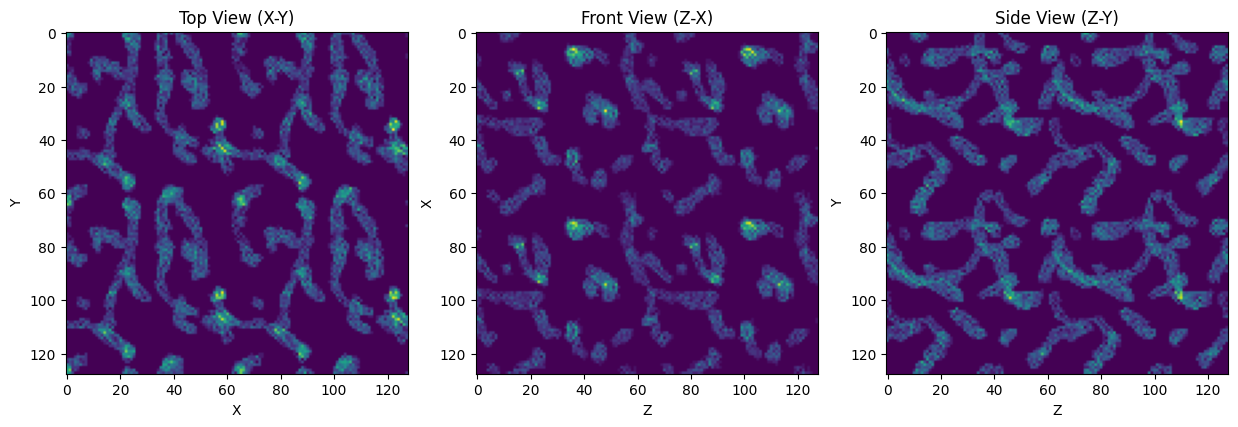

In [22]:
if conf.dev_mode:
  plot_3D_Grid(GA)  # 将 GA 替换为你的三维点阵数据

## 3.3.Home-brewing dataset

In [23]:
class myDataBase(Dataset):
    def __init__(self,
                 hdf5_3D_Grids_file_path:str,
                 excel_Performance_and_Properties_file_path:str):
        '''
        name:  'len_{i}_sigma_{j}_temp_{k}'
        label: [len_i, sigma_i, temp_i], type: pytorch tensor
        structure: 3D grid, type: pytorch tensor
        '''
        # 3D grids (h5py file)
        self.grids_hdf5     = h5py.File(hdf5_3D_Grids_file_path, 'r')

        # Performance & Properties (Excel => pd)
        self.PnP_pd     = pd.read_excel(excel_Performance_and_Properties_file_path, engine="openpyxl")
        #self.PnP_pd     = self.PnP_pd.loc[:, ['len\n(A)', 'sigma\n(A)', 'temp\n(k)', 'flux\n(L/m^2/h)', 'density\n(g/cm^3)']]

        # Sorted name list of all GA structures (h5py file)
        self.data_NameList  = self.sort_names((self.grids_hdf5.keys()))

    def __len__(self):
        return len(self.data_NameList)

    def __getitem__(self, index):
        ## 1. Index ##
        # 解析: index -> str
        name_i      = self.data_NameList[index]

        # 转换: str -> list [len_i, sigma_i, temp_i] -> tensor
        label_i     = self.extract_label_from_key(name_i)

        ## 2. Grids ##
        # 提取 (hdf5 => np.ndarray)
        grid_i      = self.grids_hdf5[name_i][:]
        # 转换: Grids (np.ndarray -> PyTorch tensor)
        grid_i      = torch.from_numpy(grid_i)

        ## 3. Performance & property data ##
        # Pandas => tensor ([item1,item2,item3...]
        items_i = fetch_from_pandas(len_i   = label_i[0].item(),
                                    sigma_i = label_i[1].item(),
                                    temp_i  = label_i[2].item(),
                                    items   = conf.DB_items,
                                    df      = self.PnP_pd)

        ## 4. 返回
        return label_i, grid_i, items_i

    def close(self):
         # 关闭h5文件，防止损坏
        self.grids_hdf5.close()

    def extract_label_from_key(self, name:str):
        # 解析数据点名称为三维张量
        len_val   = int(name.split('_')[1])
        sigma_val = int(name.split('_')[3])
        temp_val  = int(name.split('_')[-1])
        label_i   = [len_val, sigma_val, temp_val]
        return torch.tensor(label_i)

    def sort_names(self, strings:str):
        # 数据点列表名称排序
        def key_func(s):
            match = re.match(r"len_(\d+)_sigma_(\d+)_(\d+)", s)  # 提取数字
            if match:
                len_val, sigma_val, temp_val = map(int, match.groups())
                return (len_val, sigma_val, -temp_val)  # 第三个数字取反，实现降序
            else:
                return (float('inf'), float('inf'), float('-inf'))  # 处理不匹配的情况
        return sorted(strings, key=key_func)  # 排序

In [24]:
if conf.dev_mode:
  # 创建
  dataset = myDataBase(conf.DB_3D_Grids_path,conf.DB_Excel_path)

  # 读取
  label_i, grid_i, items_i  = dataset[0]
  dataset.close() # 关闭读取

  # 打印
  print(f'{label_i}\t\t{type(label_i)}\n{grid_i.shape}\t{type(grid_i)}\n{items_i}\t{type(items_i)}')

In [25]:
if conf.dev_mode:
  # 查看文件名列表
  # 长度
  print(len(dataset.data_NameList))

  # 内容
  for i in dataset.data_NameList:
      print(i)
  dataset.close() # 关闭读取

## 3.4. Data augmentation

In [26]:
def rotate_3D_Grid(matrix_3d: np.ndarray, angle_degrees: float):
    """
    绕穿过 x-y 平面的中心点且平行于 z 轴的轴旋转三维矩阵。

    Args:
        matrix_3d (numpy.ndarray): 要旋转的三维矩阵。
        angle_degrees (float): 旋转角度（以度为单位，默认逆时针）。

    Returns:
        numpy.ndarray: 旋转后的三维矩阵。
    """
    rotated_matrix = rotate(matrix_3d,
                            angle=-angle_degrees,  # 顺时针旋转
                            axes=(1, 2),  # 旋转 x-y 平面，即绕 z 轴旋转
                            reshape=False,
                            order=0,
                            mode='constant',
                            cval=0)
    return rotated_matrix

def multi_threaded_rotation(matrix_3d: np.ndarray):
    """
    并行计算 90°, 180°, 270° 三种旋转后的 3D 矩阵。

    Args:
        matrix_3d (numpy.ndarray): 要旋转的三维矩阵。

    Returns:
        dict: 包含 90°, 180°, 270° 旋转后的矩阵。
    """
    angles          = [90, 180, 270]
    rotated_results = {}

    with ThreadPoolExecutor(max_workers=3) as executor:
        results = executor.map(rotate_3D_Grid, [matrix_3d]*3, angles)

    # 存储旋转后的矩阵
    for angle, rotated_matrix in zip(angles, results):
        rotated_results[f"rotate_{angle}"] = rotated_matrix

    return rotated_results

In [27]:
if conf.dev_mode:
  # simple case
  GA = np.asarray([
                  [[2,3,4],  # z = 3
                  [1,2,3],
                  [0,1,2]],
                  [[2,2,2],   # z = 3
                  [2,2,2],
                  [2,2,2]],
                  [[1,1,1],   # z = 2
                  [1,1,1],
                  [1,1,1]],
                  [[0,0,0],   # z = 1
                  [0,0,0],
                  [0,0,0]],
                  [[0,0,0],   # z = 0
                  [0,0,0],
                  [0,0,0]]]
                  )

  # 示例测试
  rotated_matrices = multi_threaded_rotation(GA)

  # 获取旋转后的结果
  rotate_90  = rotated_matrices["rotate_90"]
  rotate_180 = rotated_matrices["rotate_180"]
  rotate_270 = rotated_matrices["rotate_270"]

  # 输出形状检查
  print(rotate_90.shape, rotate_180.shape, rotate_270.shape)

  # plot
  plot_3D_Grid(GA)
  plot_3D_Grid(rotate_90)
  plot_3D_Grid(rotate_180)
  plot_3D_Grid(rotate_270)

In [28]:
if conf.dev_mode:
  DB_3D_Grids = h5py.File(conf.DB_3D_Grids_path, "r")
  GA          = DB_3D_Grids[f"len_{2}_sigma_{18}_{343}"][:]


  # 示例测试
  rotated_matrices = multi_threaded_rotation(GA)

  # 获取旋转后的结果
  rotate_90  = rotated_matrices["rotate_90"]
  rotate_180 = rotated_matrices["rotate_180"]
  rotate_270 = rotated_matrices["rotate_270"]

  # 输出形状检查
  print(rotate_90.shape, rotate_180.shape, rotate_270.shape)

  # plot
  plot_3D_Grid(GA)
  plot_3D_Grid(rotate_90)
  plot_3D_Grid(rotate_180)
  plot_3D_Grid(rotate_270)

In [29]:
class RotatedDataBase(myDataBase):
    """
    3D 矩阵旋转数据集，返回 90°, 180°, 270° 旋转后的矩阵。
    """
    def __init__(self, base_dataset):
        """
        初始化数据集。

        Args:
            data_list (list of np.ndarray): 原始 3D 矩阵列表，每个矩阵 shape=(400,400,400)。
        """
        self.base_dataset     = base_dataset                # 原始数据集
        self.rotation_angles  = [0, 90, 180, 270]           # 旋转角度
        self.num_rotations    = len(self.rotation_angles)   # 旋转次数
        #self.data_NameList    = base_dataset.data_NameList  # 数据点列表名称

    def __len__(self):
        """
        数据集大小
        """
        return int(len(self.base_dataset)*(self.num_rotations))

    def __getitem__(self, new_idx):
        """
        获取数据并返回旋转后的4个版本
        Returns:
            dict: {"original":   原始 3D 矩阵,
                   "rotate_90":  顺时旋转 90°,
                   "rotate_180": 顺时旋转 180°,
                   "rotate_270": 顺时旋转 270°}
        """
        # 计算index
        rotation_idx    = new_idx %  (self.num_rotations)  # index within the rotation group
        original_idx    = new_idx // (self.num_rotations)  # index in the oringal base dataset

        # 原始矩阵
        label_i, grid_i, items_i  = self.base_dataset[original_idx]

        # 旋转
        rotated_grid_i = rotate_3D_Grid(matrix_3d=grid_i, angle_degrees=self.rotation_angles[rotation_idx])

        # 确保转换为 float32 的 PyTorch Tensor
        rotated_grid_i = torch.from_numpy(rotated_grid_i).to(torch.float32)

        # 添加 channel 维度 (channels, depth, height, width)
        rotated_grid_i = rotated_grid_i.unsqueeze(0)

        # 返回
        return  label_i, rotated_grid_i, items_i

In [30]:
if conf.dev_mode:
  # 创建
  dataset = myDataBase(conf.DB_3D_Grids_path,conf.DB_Excel_path)

  # Augmentation
  rotated_dataset = RotatedDataBase(dataset)

  for idx in [0,1,2,3]:
    idx += (11*4)
    print(idx)
    label_i, grid_i, items_i = rotated_dataset[idx]

    print(f'check-{dataset.data_NameList[idx//4]}')

    print(label_i, grid_i.shape, items_i)
    print(type(grid_i))

In [31]:
# loader speed test
if False:



  def load_data_item(dataset, index):
      """
      加载单个数据项
      """
      _, _, _ = dataset[index]


  def calculate_loading_time_multithreaded(dataset, num_threads=4):
      """使用多线程计算加载数据集所需的时间。"""
      start_time = time.time()

      with ThreadPoolExecutor(max_workers=num_threads) as executor:
          # 创建任务列表，每个任务加载一个数据项
          tasks = [executor.submit(load_data_item, dataset, i) for i in range(len(dataset))]

          # 使用 tqdm 显示进度条，并等待所有任务完成
          for _ in tqdm(tasks, total=len(tasks), desc="多线程加载数据集..."):
              _.result()  # 获取任务结果，以确保任务已完成

      end_time = time.time()
      total_time = end_time - start_time

      return total_time


  # 创建数据集
  dataset = myDataBase(conf.DB_3D_Grids_path, conf.DB_Excel_path)
  rotated_dataset = RotatedDataBase(dataset)

  # 计算并打印加载时间
  loading_time = calculate_loading_time_multithreaded(rotated_dataset, num_threads=int(psutil.cpu_count(logical=True)))
  print(f"使用多线程加载整个 rotated_dataset 所需时间：{loading_time:.2f} 秒")

# 4.Model Preparation

In [32]:
class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1)   # 维度不变
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)  # 维度不变
        self.pool  = nn.MaxPool3d(2, 2)                 # 2x2x2 池化，尺寸减半
        self.fc1   = nn.Linear(32 * 32 * 32 * 32, 128)  # 调整输入维度
        self.fc2   = nn.Linear(128, 2)                  # 输出2个值

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128x128x128 -> 64x64x64
        x = self.pool(F.relu(self.conv2(x)))  # 64x64x64 -> 32x32x32
        x = x.view(-1, 32 * 32 * 32 * 32)     # 修改 reshape 维度
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [33]:
class Improved3DCNN(nn.Module):
    def __init__(self):
        super(Improved3DCNN, self).__init__()
        self.conv1  = nn.Conv3d(1,  16, kernel_size=3, stride=1, padding=1)
        self.conv2  = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool   = nn.MaxPool3d(2, 2)        # 2x2x2 池化，尺寸减半

        self.fc1          = nn.Linear(32 * 32 * 32 * 32, 128)               # CNN 提取的特征
        self.transformer  = TransformerEncoderLayer(d_model=128, nhead=4)   # Transformer 处理特征
        self.fc2          = nn.Linear(128 + 1, 64)                          # 只加入 temp_i（1 维）
        self.fc3          = nn.Linear(64, 2)                                # 输出2个值

    def forward(self, x, items_i):
        x = self.pool(F.relu(self.conv1(x)))  # 128³ -> 64³
        x = self.pool(F.relu(self.conv2(x)))  # 64³ -> 32³
        x = x.view(-1, 32 * 32 * 32 * 32)     # 展平

        x = F.relu(self.fc1(x))             # fc1 out: CNN 特征提取
        x = x.unsqueeze(0)                  # Transformer 输入需要 (seq_len, batch, feature_dim)
        x = self.transformer(x)             # 通过 Transformer 处理
        x = x.squeeze(0)                    # 恢复 batch 维度

        temp_i  = items_i[:, 2].unsqueeze(1)       # 只取 temp_i，形状变为 (batch_size, 1)
        x       = torch.cat((x, temp_i), dim=1)    # 拼接 temp_i

        x = F.relu(self.fc2(x))             # fc2 out: relu
        x = self.fc3(x)                     # fc3 out: 输出最终结果
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=128, nhead=4, dim_feedforward=256, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

    def forward(self, x):
        return self.transformer(x)

5. Load Data

In [45]:
# 设定训练集和测试集比例
train_ratio = 0.8  # 80% 训练集, 20% 测试集

# 读取数据集
dataset         = myDataBase(conf.DB_3D_Grids_path, conf.DB_Excel_path)
rotated_dataset = RotatedDataBase(dataset)  # 数据增强

# 计算划分数量
train_size      = int(train_ratio * len(rotated_dataset))
test_size       = len(rotated_dataset) - train_size

# 随机划分数据集
train_dataset, test_dataset = random_split(rotated_dataset, [train_size, test_size])

# 生成 DataLoader
train_loader    = DataLoader(train_dataset, batch_size=12, shuffle=True,  num_workers=12)
test_loader     = DataLoader(test_dataset,  batch_size=12, shuffle=False, num_workers=12)

if conf.dev_mode:
  print(f"训练集大小: {len(train_dataset)}, 测试集大小: {len(test_dataset)}")

# 5.Model Trainning

In [38]:
device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model           = Improved3DCNN().to(device)
optimizer       = optim.Adam(model.parameters(), lr=0.0005)
criterion       = nn.MSELoss()
num_epochs      = 10

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [39]:
# 训练
for epoch in range(num_epochs):
    running_loss = 0.0
    for label, grid, items in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        label, grid, items = label.to(device), grid.to(device), items.to(device)

        optimizer.zero_grad()
        output        = model(grid,label)
        loss          = criterion(output, items)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# 保存模型
torch.save(model.state_dict(), "3d_cnn_model.pth")
print("✅ 模型训练完成，已保存！")

Epoch 1/10: 100%|██████████| 223/223 [00:58<00:00,  3.79it/s]


Epoch: 1/10, Loss: 1698.0872


Epoch 2/10: 100%|██████████| 223/223 [00:59<00:00,  3.78it/s]


Epoch: 2/10, Loss: 1053.8386


Epoch 3/10: 100%|██████████| 223/223 [00:59<00:00,  3.77it/s]


Epoch: 3/10, Loss: 770.8981


Epoch 4/10: 100%|██████████| 223/223 [00:59<00:00,  3.75it/s]


Epoch: 4/10, Loss: 561.7039


Epoch 5/10: 100%|██████████| 223/223 [00:58<00:00,  3.80it/s]


Epoch: 5/10, Loss: 1545.8001


Epoch 6/10: 100%|██████████| 223/223 [00:59<00:00,  3.77it/s]


Epoch: 6/10, Loss: 823.8968


Epoch 7/10: 100%|██████████| 223/223 [00:59<00:00,  3.76it/s]


Epoch: 7/10, Loss: 499.2426


Epoch 8/10: 100%|██████████| 223/223 [00:59<00:00,  3.73it/s]


Epoch: 8/10, Loss: 340.7223


Epoch 9/10: 100%|██████████| 223/223 [00:59<00:00,  3.78it/s]


Epoch: 9/10, Loss: 165.1424


Epoch 10/10: 100%|██████████| 223/223 [00:58<00:00,  3.78it/s]


Epoch: 10/10, Loss: 110.9465
模型训练完成，已保存！


# 6.Model Evaluation

In [48]:
# 加载模型
model = Improved3DCNN().to(device)                    # Create an instance of your model
model.load_state_dict(torch.load('3d_cnn_model.pth')) # Load the saved state_dict
model.eval()                                          # Set the model to evaluation mode

# 用于存储预测值和真实值
predictions   = []
actual_values = []

# 用于存储总的损失
total_loss    = 0.0
criterion     = nn.MSELoss()

with torch.no_grad():
    for label, grid, items in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        label, grid, items = label.to(device), grid.to(device), items.to(device)

        output      = model(grid, label)
        loss        = criterion(output, items)
        total_loss += loss.item()

print(f"Test Loss: {total_loss / len(test_loader):.4f}")
dataset.close()

<ipython-input-48-2abb663a75ae>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('3d_cnn_model.pth')
Epoch 10/10:   0%|          | 0/56 [00:06<?, ?it/s]


TypeError: 'collections.OrderedDict' object is not callable

In [ ]:
# 打印平均损失
average_loss = total_loss / len(test_loader)
print(f'Average loss on the test data: {average_loss:.3f}')

In [ ]:
# 转换为 numpy 数组，方便绘图
predictions = np.array(predictions)
actual_values = np.array(actual_values)

# 1. 绘制第一个目标值的预测值 vs 真实值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(actual_values[:, 0], predictions[:, 0], c='blue', label='Predictions')
plt.plot([min(actual_values[:, 0]), max(actual_values[:, 0])],
         [min(actual_values[:, 0]), max(actual_values[:, 0])], 'r--', label='Ideal fit')
plt.xlabel('Actual Values (Target 1)')
plt.ylabel('Predicted Values (Target 1)')
plt.title('Predicted vs Actual Values (Target 1)')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('Predicted vs Actual Values (Target 1)')

# 2. 绘制第二个目标值的预测值 vs 真实值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(actual_values[:, 1], predictions[:, 1], c='blue', label='Predictions')
plt.plot([min(actual_values[:, 1]), max(actual_values[:, 1])],
         [min(actual_values[:, 1]), max(actual_values[:, 1])], 'r--', label='Ideal fit')
plt.xlabel('Actual Values (Target 2)')
plt.ylabel('Predicted Values (Target 2)')
plt.title('Predicted vs Actual Values (Target 2)')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('Predicted vs Actual Values (Target 2)')

# 3. 绘制第一个目标值的误差分布图
errors_1 = predictions[:, 0] - actual_values[:, 0]
plt.figure(figsize=(10, 6))
plt.hist(errors_1, bins=25, color='purple', edgecolor='black')
plt.xlabel('Prediction Error (Target 1)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Target 1)')
plt.grid(True)
plt.show()
plt.savefig('Distribution of Prediction Errors (Target 1)')

# 4. 绘制第二个目标值的误差分布图
errors_2 = predictions[:, 1] - actual_values[:, 1]
plt.figure(figsize=(10, 6))
plt.hist(errors_2, bins=25, color='purple', edgecolor='black')
plt.xlabel('Prediction Error (Target 2)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Target 2)')
plt.grid(True)
plt.show()
plt.savefig('Distribution of Prediction Errors (Target 2)')

# 5. 绘制第一个目标值的误差 vs 真实值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(actual_values[:, 0], errors_1, c='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values (Target 1)')
plt.ylabel('Prediction Error (Target 1)')
plt.title('Prediction Error vs Actual Values (Target 1)')
plt.grid(True)
plt.show()
plt.savefig('Prediction Error vs Actual Values (Target 1)')

# 6. 绘制第二个目标值的误差 vs 真实值的散点图
plt.figure(figsize=(10, 6))
plt.scatter(actual_values[:, 1], errors_2, c='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values (Target 2)')
plt.ylabel('Prediction Error (Target 2)')
plt.title('Prediction Error vs Actual Values (Target 2)')
plt.grid(True)
plt.show()
plt.savefig('Prediction Error vs Actual Values (Target 2)')